# Prediction with a pre-trained model (TensorFlow)

This notebook demonstrates how to use a pre-trained 3D U-Net model to perform fault segmentation on new seismic data. It covers two scenarios:
1.  **Simple Prediction:** Running inference on a single data cube (e.g., from the validation set) to quickly check model performance.
2.  **Complex Prediction:** Running inference on a large field data volume that is bigger than the model's input size. This requires a tiling (or patching) approach with overlapping and blending to produce a smooth, final result.

## Step 1: Import Libraries and Configure Environment

First, we import the necessary libraries and configure the GPU. This setup is identical to our training notebook to ensure consistency.

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# TensorFlow Keras imports
from tensorflow.keras.models import load_model
from unet3_tf import * #unet

2025-07-29 18:30:16.399504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753806616.418378  201829 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753806616.424604  201829 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753806616.440100  201829 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753806616.440138  201829 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753806616.440140  201829 computation_placer.cc:177] computation placer alr

In [2]:
# Check for GPU availability and configure it
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1753806620.250536  201829 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21746 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:41:00.0, compute capability: 8.6


## Step 2: Define Paths and Parameters

Here we define the paths to our data and the trained model. **Make sure `model_name` points to the specific `.keras` model file you want to use for prediction.**

In [3]:
# --- Base Directory (Ensure this matches your training notebook's setup) ---
base_dir = "/home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras"

# --- Data Paths ---
original_data_dir = os.path.join(base_dir, "data_from_Wu")
processed_data_dir = os.path.join(base_dir, "data_processed_npy")
validation_dir_new = os.path.join(processed_data_dir, 'validation')
prediction_dir_f3d = os.path.join(original_data_dir, "prediction/f3d") # For the large field data

# --- Model Path ---
model_dir = os.path.join(base_dir, "model")
# !!! IMPORTANT: Set the name of the model you want to load !!!
model_name = "unet_tf_model_200pairs_10epochs_2025-07-29_18-18-55.keras" # Example name, replace with your actual model file
model_path = os.path.join(model_dir, model_name)

# --- Model Input Parameters (Must match training) ---
patch_n1, patch_n2, patch_n3 = 128, 128, 128

## Step 3: Load the Trained Model

We load the compiled model from the specified `.keras` file. Since we used a standard loss function (`binary_crossentropy`), we don't need to provide any `custom_objects`.

In [5]:
## Step 3 · Load the trained model
print(f"Loading model from: {model_path}")

if not os.path.exists(model_path):
    raise FileNotFoundError(
        f"Model file not found at {model_path}. Please check the path and filename."
    )

# ------------------------------------------------------------------
# Tell Keras how to find the custom loss function when deserialising
# ------------------------------------------------------------------
model = load_model(
    model_path,
    custom_objects={"cross_entropy_balanced": cross_entropy_balanced}
)  #  ← added argument
model.summary()

Loading model from: /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/model/unet_tf_model_200pairs_10epochs_2025-07-29_18-18-55.keras


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_15 (Conv3D)  │ (None, 128, 128,  │        448 │ input_layer_1[0]… │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_16 (Conv3D)  │ (None, 128, 128,  │      6,928 │ conv3d_15[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_3     │ (None, 64, 64,    │          0 │ conv3d_16[0][0]   │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_17 (Conv3D)  │ (None, 64, 64,    │     13,856 │ max_pooling3d_3[… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_18 (Conv3D)  │ (None, 64, 64,    │     27,680 │ conv3d_17[0][0]   │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_4     │ (None, 32, 32,    │          0 │ conv3d_18[0][0]   │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_19 (Conv3D)  │ (None, 32, 32,    │     55,360 │ max_pooling3d_4[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_20 (Conv3D)  │ (None, 32, 32,    │    110,656 │ conv3d_19[0][0]   │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_5     │ (None, 16, 16,    │          0 │ conv3d_20[0][0]   │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_21 (Conv3D)  │ (None, 16, 16,    │    221,312 │ max_pooling3d_5[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_22 (Conv3D)  │ (None, 16, 16,    │    442,496 │ conv3d_21[0][0]   │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling3d_3     │ (None, 32, 32,    │          0 │ conv3d_22[0][0]   │
│ (UpSampling3D)      │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 32, 32,    │          0 │ up_sampling3d_3[… │
│ (Concatenate)       │ 32, 192)          │            │ conv3d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_23 (Conv3D)  │ (None, 32, 32,    │    331,840 │ concatenate_3[0]… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_24 (Conv3D)  │ (None, 32, 32,    │    110,656 │ conv3d_23[0][0]   │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling3d_4     │ (None, 64, 64,    │          0 │ conv3d_24[0][0] 

 Total params: 4,378,757 (16.70 MB)

 Trainable params: 1,459,585 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,919,172 (11.14 MB)

## Step 4: Simple Prediction on a Validation Sample

This is a sanity check to ensure the model loads and predicts correctly. We will take one sample from the validation set, apply the *exact same* preprocessing as in training, and visualize the result.

I0000 00:00:1753806764.216179  201982 service.cc:152] XLA service 0x7d44c400af70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753806764.216254  201982 service.cc:160]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2025-07-29 18:32:44.243110: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753806764.326714  201982 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-07-29 18:32:45.197741: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-29 18:32:45.344175: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please i

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


I0000 00:00:1753806768.554331  201982 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Displaying slice 64 from validation sample 10


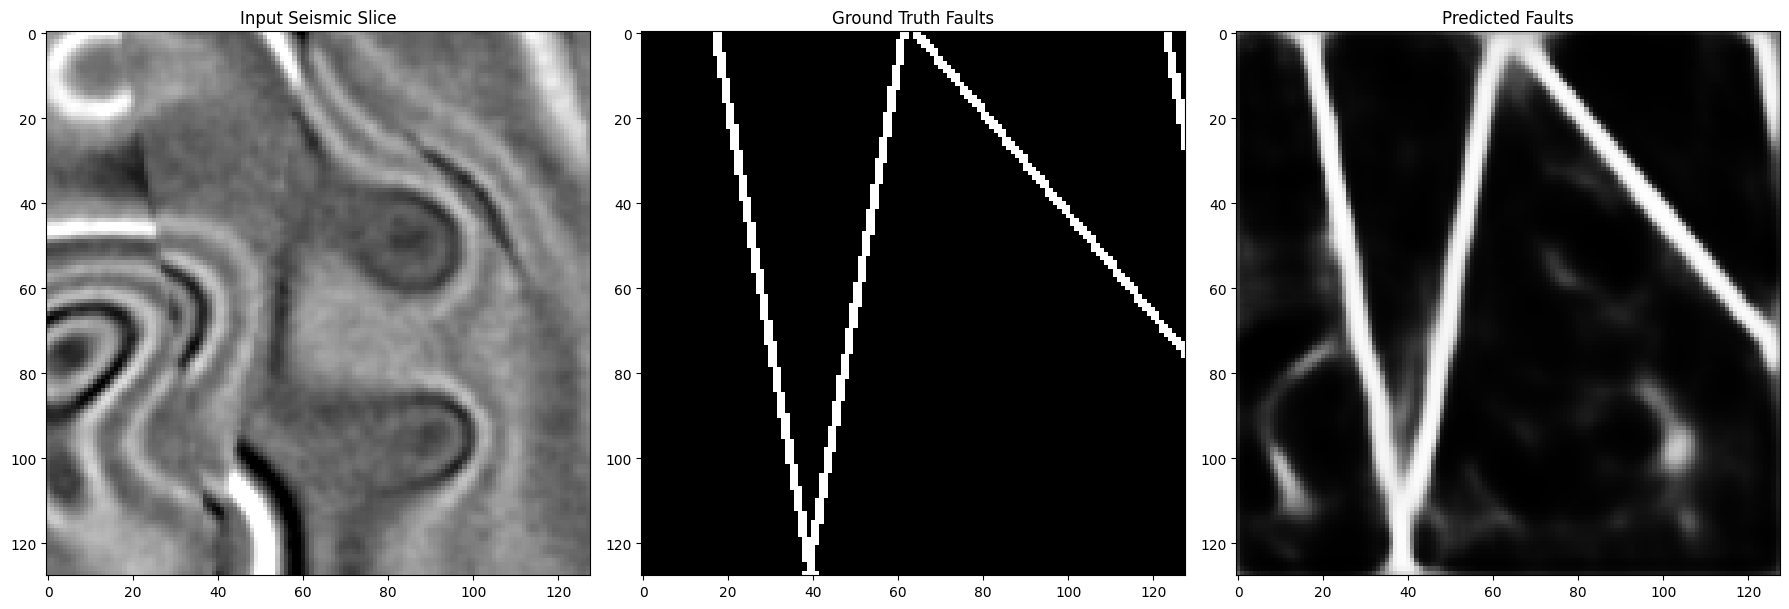

In [6]:
def plot_prediction_slices(gx_slice, fx_slice, fp_slice):
    """Plots the input, ground truth, and prediction slices side-by-side."""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    ax1.set_title("Input Seismic Slice")
    ax1.imshow(gx_slice.T, cmap='gray', vmin=-2, vmax=2) # Transpose for correct viewing orientation
    
    ax2.set_title("Ground Truth Faults")
    ax2.imshow(fx_slice.T, cmap='gray', vmin=0, vmax=1)
    
    ax3.set_title("Predicted Faults")
    ax3.imshow(fp_slice.T, cmap='gray', vmin=0, vmax=1)
    
    plt.tight_layout()
    plt.show()

# --- Load a validation sample ---
sample_id = '10' # Use sample '10.npy'
gx_orig = np.load(os.path.join(validation_dir_new, 'seis', f'{sample_id}.npy'))
fx_orig = np.load(os.path.join(validation_dir_new, 'fault', f'{sample_id}.npy'))

# --- Preprocessing (MUST MATCH TRAINING DATAGENERATOR) ---
gx_processed = (gx_orig - np.mean(gx_orig)) / (np.std(gx_orig) + 1e-8)
gx_transposed = np.transpose(gx_processed)
fx_transposed = np.transpose(fx_orig)

# --- Predict ---
# Add batch and channel dimensions for the model input
input_tensor = np.reshape(gx_transposed, (1, patch_n1, patch_n2, patch_n3, 1))
fp_transposed = model.predict(input_tensor)[0, :, :, :, 0]

# --- Visualize a slice ---
slice_idx = 64
print(f"Displaying slice {slice_idx} from validation sample {sample_id}")
plot_prediction_slices(gx_transposed[slice_idx,:,:], fx_transposed[slice_idx,:,:], fp_transposed[slice_idx,:,:])

## Step 5: Complex Prediction on a Large Field Image (Tiling/Patching)

Real-world seismic volumes are much larger than the model's `128x128x128` input size. To handle this, we use a patch-based approach:
1.  **Padding:** The large volume is padded with zeros to ensure it's perfectly divisible by our patch-and-stride logic.
2.  **Tiling:** We slide a `128x128x128` window across the padded volume with a defined overlap.
3.  **Blending:** To avoid sharp edges in the final prediction, we use a Gaussian mask. Predictions in the center of a patch have a higher weight than those at the edges.
4.  **Stitching:** We accumulate the weighted predictions and the weights themselves. The final fault probability at each point is the sum of weighted predictions divided by the sum of weights.

In [7]:
def create_gaussian_mask(overlap_size, n1, n2, n3):
    """Creates a 3D Gaussian mask for smooth blending of patches."""
    sc = np.zeros((n1, n2, n3), dtype=np.single)
    # Use overlap_size instead of os
    sig = overlap_size / 4.0
    sig = 0.5 / (sig * sig)
    
    sp = np.zeros(overlap_size, dtype=np.single)
    for i in range(overlap_size):
        ds = i - overlap_size + 1
        sp[i] = np.exp(-ds * ds * sig)
        
    for i in range(n1):
        for j in range(n2):
            for k in range(n3):
                sc[i,j,k] = 1.0
                
    for i in range(overlap_size):
        sc[i,:,:] *= sp[i]
        sc[n1-1-i,:,:] *= sp[i]
        sc[:,i,:] *= sp[i]
        sc[:,n2-1-i,:] *= sp[i]
        sc[:,:,i] *= sp[i]
        sc[:,:,n3-1-i] *= sp[i]
    return sc

# --- 1. Load Large Seismic Volume ---
f3d_path = os.path.join(prediction_dir_f3d, 'gxl.dat')
m3, m2, m1 = 512, 384, 128
gx = np.fromfile(f3d_path, dtype=np.single).reshape(m3, m2, m1)
print(f"Loaded F3 field data with shape: {gx.shape}")

gx = np.transpose(gx)
m1, m2, m3 = gx.shape
print(f"Transposed shape for processing: {gx.shape}")

# --- 2. Setup Tiling Parameters ---
# --- FIX: Renamed 'os' to 'overlap_size' to avoid conflict with the os module ---
overlap_size = 12
stride = (patch_n1 - overlap_size, patch_n2 - overlap_size, patch_n3 - overlap_size)

# Calculate padding needed
p1 = (stride[0] - (m1 - patch_n1) % stride[0]) % stride[0]
p2 = (stride[1] - (m2 - patch_n2) % stride[1]) % stride[1]
p3 = (stride[2] - (m3 - patch_n3) % stride[2]) % stride[2]
gp = np.pad(gx, ((0,p1), (0,p2), (0,p3)), mode='constant', constant_values=0)
padded_shape = gp.shape

# --- 3. Initialize Output and Run Prediction Loop ---
gy = np.zeros(padded_shape, dtype=np.single)
mk = np.zeros(padded_shape, dtype=np.single)
sc = create_gaussian_mask(overlap_size, patch_n1, patch_n2, patch_n3)

k1_range = range(0, padded_shape[0] - patch_n1 + 1, stride[0])
k2_range = range(0, padded_shape[1] - patch_n2 + 1, stride[1])
k3_range = range(0, padded_shape[2] - patch_n3 + 1, stride[2])

print("\nStarting tiling prediction on large volume...")
for k1 in tqdm(k1_range, desc="Dim 1/3"):
    for k2 in k2_range:
        for k3 in k3_range:
            patch = gp[k1:k1+patch_n1, k2:k2+patch_n2, k3:k3+patch_n3]
            patch_processed = (patch - np.mean(patch)) / (np.std(patch) + 1e-8)
            
            input_patch = np.reshape(patch_processed, (1, patch_n1, patch_n2, patch_n3, 1))
            predicted_patch = model.predict(input_patch, verbose=0)[0,:,:,:,0]
            
            gy[k1:k1+patch_n1, k2:k2+patch_n2, k3:k3+patch_n3] += predicted_patch * sc
            mk[k1:k1+patch_n1, k2:k2+patch_n2, k3:k3+patch_n3] += sc

# --- 4. Finalize by Averaging and Cropping ---
gy = np.divide(gy, mk, out=np.zeros_like(gy), where=mk!=0)
fp_final = gy[:m1, :m2, :m3]

print(f"\nPrediction complete. Final fault probability map shape: {fp_final.shape}")

# Now this line will work because the 'os' module has not been overwritten
output_filename = os.path.join(prediction_dir_f3d, "fp_tensorflow.dat")
fp_final.astype(np.single).tofile(output_filename)
print(f"Final prediction saved to: {output_filename}")

Loaded F3 field data with shape: (512, 384, 128)
Transposed shape for processing: (128, 384, 512)

Starting tiling prediction on large volume...


Dim 1/3:   0%|          | 0/1 [00:00<?, ?it/s]


Prediction complete. Final fault probability map shape: (128, 384, 512)
Final prediction saved to: /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/data_from_Wu/prediction/f3d/fp_tensorflow.dat


## Step 6: Visualize the Field Prediction Results

Now we can load the original seismic data and our final fault prediction to compare them visually on different slices.

Seismic data shape for plotting: (512, 384, 128)
Prediction data shape for plotting: (512, 384, 128)


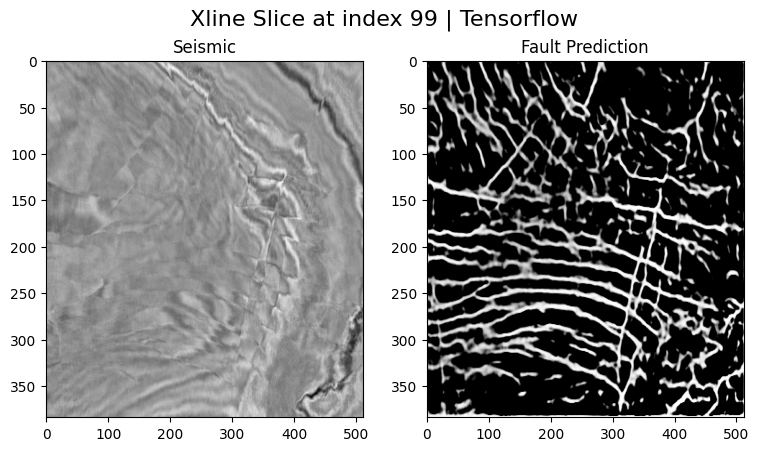

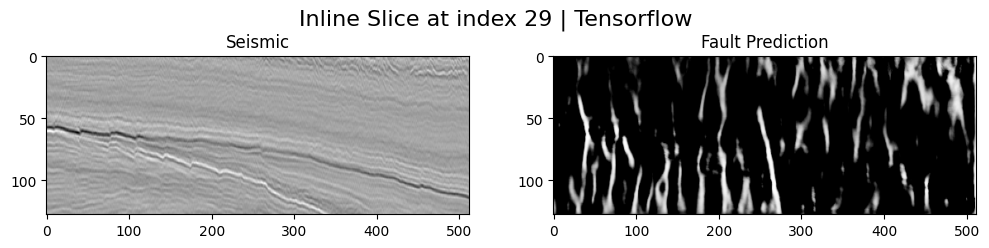

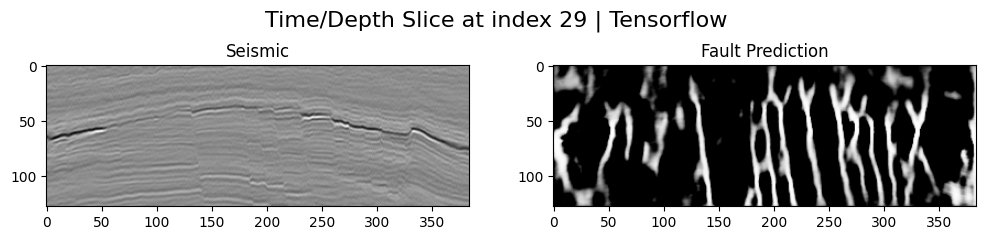

In [8]:
# --- 1. Reload Data in Original Orientation ---
# This ensures our slicing logic matches the author's exactly.
# Original dimensions are (depth, inline, xline)
m3, m2, m1 = 512, 384, 128 

# Load the original seismic volume
seismic_path = os.path.join(prediction_dir_f3d, 'gxl.dat')
gx_orig_view = np.fromfile(seismic_path, dtype=np.single).reshape(m3, m2, m1)

# Load the fault prediction we just saved
prediction_path = os.path.join(prediction_dir_f3d, "fp_tensorflow.dat")
# The saved fp_final was (xline, inline, depth), so we transpose it back
# to match the original seismic orientation for consistent slicing.
fp_transposed = np.fromfile(prediction_path, dtype=np.single).reshape(m1, m2, m3)
fp_orig_view = np.transpose(fp_transposed)

print(f"Seismic data shape for plotting: {gx_orig_view.shape}")
print(f"Prediction data shape for plotting: {fp_orig_view.shape}")


# --- 2. Define Slice Indices (from original notebook) ---
k1_depth, k2_inline, k3_xline = 29, 29, 99


# --- 3. Plot Each Slice Type in a Separate Figure ---

# --- Xline Slice ---
gx_slice = gx_orig_view[:, :, k3_xline]
fp_slice = fp_orig_view[:, :, k3_xline]
fig = plt.figure(figsize=(9, 9))
# --- FIX: Added y=0.92 to move the title down ---
plt.suptitle(f'Xline Slice at index {k3_xline} | Tensorflow', fontsize=16, y=0.75)
# Seismic
p1 = plt.subplot(1, 2, 1)
p1.set_title("Seismic")
p1.imshow(np.transpose(gx_slice), aspect=1.5, cmap=plt.cm.gray)
# Prediction
p2 = plt.subplot(1, 2, 2)
p2.set_title("Fault Prediction")
p2.imshow(np.transpose(fp_slice), aspect=1.5, interpolation="bilinear", vmin=0.4, vmax=1.0, cmap=plt.cm.gray)
plt.show()


# --- Inline Slice ---
gx_slice = gx_orig_view[:, k2_inline, :]
fp_slice = fp_orig_view[:, k2_inline, :]
fig = plt.figure(figsize=(12, 12))
# --- FIX: Added y=0.92 to move the title down ---
plt.suptitle(f'Inline Slice at index {k2_inline} | Tensorflow', fontsize=16, y=0.6)
# Seismic
p1 = plt.subplot(1, 2, 1)
p1.set_title("Seismic")
p1.imshow(np.transpose(gx_slice), aspect=1.5, cmap=plt.cm.gray)
# Prediction
p2 = plt.subplot(1, 2, 2)
p2.set_title("Fault Prediction")
p2.imshow(np.transpose(fp_slice), aspect=1.5, interpolation="bilinear", vmin=0.4, vmax=1.0, cmap=plt.cm.gray)
plt.show()


# --- Time/Depth Slice ---
gx_slice = gx_orig_view[k1_depth, :, :]
fp_slice = fp_orig_view[k1_depth, :, :]
fig = plt.figure(figsize=(12, 12))
# --- FIX: Added y=0.92 to move the title down ---
plt.suptitle(f'Time/Depth Slice at index {k1_depth} | Tensorflow', fontsize=16, y=0.6)
# Seismic
p1 = plt.subplot(1, 2, 1)
p1.set_title("Seismic")
p1.imshow(np.transpose(gx_slice), cmap=plt.cm.gray)
# Prediction
p2 = plt.subplot(1, 2, 2)
p2.set_title("Fault Prediction")
p2.imshow(np.transpose(fp_slice), interpolation="bilinear", vmin=0.4, vmax=1.0, cmap=plt.cm.gray)
plt.show()